数据概览:
           日期  唯一编号  性别  年龄   C反应蛋白  N末端B型钠尿肽原测定  α羟基丁酸脱氢酶  中性粒细胞绝对值    乳酸脱氢酶  \
0  2021-10-11     1   1  64    2.04        607.5     676.0      7.71   686.85   
1  2021-10-12     1   1  64    4.40       2475.2     926.0      6.47   904.60   
2  2021-10-13     1   1  64   11.50       2855.7     596.0      7.49   604.00   
3  2021-11-24     3   1  47   47.30       2883.8    2042.0     21.33  1545.50   
4  2021-11-26     3   1  47  121.20       3600.0    1060.0     14.15  1177.60   

   二氧化碳  ...  甘油三酯   白细胞   白蛋白  直接胆红素  红细胞沉降率  谷丙转氨酶  间接胆红素  高密度脂蛋白  同型半胱氨酸  \
0  28.8  ...  1.53   3.7  41.9    4.8      11   31.5   15.4    0.87    22.4   
1  23.7  ...  2.61   5.0  40.6    5.8      10   43.0   15.4    0.87    19.1   
2  22.1  ...  1.58  71.7  39.4    3.6      39   31.5    6.7    0.87    15.9   
3  22.2  ...  0.52   3.8  39.8    6.5       7   89.0   15.6    1.33    24.6   
4  26.0  ...  1.58   2.2  32.1    4.2      30   80.0    7.8    0.95    35.4   

   住院日序号  
0      1  
1      2  

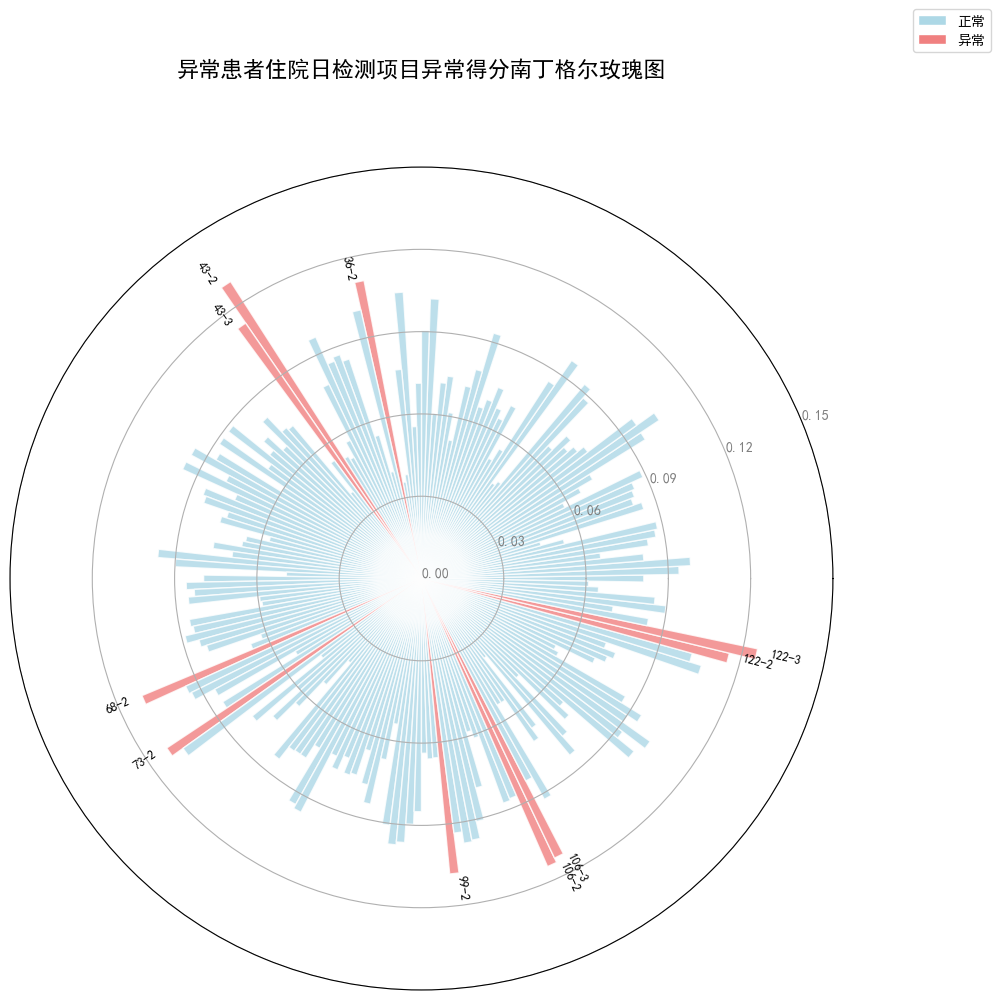

南丁格尔玫瑰图已保存到: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\nightingale_rose_plot_with_custom_colors.png


<Figure size 640x480 with 0 Axes>

In [8]:
# ==========================
# 1. 导入必要的库
# ==========================
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 设置中文字体（例如 SimHei）以支持中文显示
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

# ==========================
# 2. 数据加载与预处理
# ==========================

# 定义文件路径
data_path = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\data_GAN.csv'

# 读取CSV文件
data = pd.read_csv(data_path)

# 查看数据基本信息
print("数据概览:")
print(data.head())
print("\n数据描述:")
print(data.describe())
print("\n数据类型:")
print(data.dtypes)

# 排除非特征列
exclude_cols = ['唯一编号', '日期', '住院日序号', '性别', '年龄']
feature_cols = [col for col in data.columns if col not in exclude_cols]

# 确保特征列为数值型，并处理缺失值（填充为均值）
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors='coerce')
data[feature_cols] = data[feature_cols].fillna(data[feature_cols].mean())

# 查看缺失值情况
print("\n缺失值情况:")
print(data[feature_cols].isnull().sum())

# 按照唯一编号和住院日序号排序
data = data.sort_values(by=['唯一编号', '住院日序号']).reset_index(drop=True)

# ==========================
# 3. 构建滑动窗口特征
# ==========================

# 定义滑动窗口大小
window_size = 2  # 2天滑动窗口

# 初始化一个空的列表来存储窗口特征
window_features = []

# 获取唯一的患者编号
unique_ids = data['唯一编号'].unique()

# 遍历每个患者
for uid in unique_ids:
    patient_data = data[data['唯一编号'] == uid].sort_values('住院日序号')
    patient_data = patient_data.reset_index(drop=True)
    num_days = patient_data.shape[0]

    # 对每个检测项目应用滑动窗口
    for project in feature_cols:
        project_values = patient_data[project].values

        # 创建滑动窗口
        for i in range(num_days - window_size + 1):
            window = project_values[i:i + window_size]
            day1, day2 = window

            # 计算特征
            change = day2 - day1
            mean_val = np.mean(window)
            var_val = np.var(window)

            # 对应的住院日序号（窗口的第二天）
            hospital_day = patient_data.loc[i + window_size - 1, '住院日序号']

            # 存储特征
            window_features.append({
                '唯一编号': uid,
                '住院日序号': hospital_day,
                '检测项目': project,
                'change': change,
                'mean_val': mean_val,
                'var_val': var_val
            })

# 转换为DataFrame
features_df = pd.DataFrame(window_features)

print("\n滑动窗口特征数据概览:")
print(features_df.head())
print("\n滑动窗口特征数据描述:")
print(features_df.describe())

# ==========================
# 4. 特征标准化
# ==========================

# 选择特征
feature_columns = ['change', 'mean_val', 'var_val']

# 提取特征矩阵
X = features_df[feature_columns].values

# 标准化特征
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# 5. 训练全局孤立森林模型并计算异常分数
# ==========================

# 训练孤立森林模型
iso_model = IsolationForest(n_estimators=100, contamination='auto', random_state=123)
iso_model.fit(X_scaled)

# 计算异常分数
# IsolationForest的decision_function返回的分数：越高越正常，越低越异常
# 通过取相反数使得异常分数越高越异常
anomaly_scores = -iso_model.decision_function(X_scaled)

# 添加异常分数到DataFrame
features_df['anomaly_score'] = anomaly_scores

# ==========================
# 6. 标准化异常分数
# ==========================

# 使用MinMaxScaler将异常分数缩放到[0,1]
scaler_score = MinMaxScaler()
features_df['anomaly_score_normalized'] = scaler_score.fit_transform(features_df[['anomaly_score']])

print("\n标准化后的异常分数数据概览:")
print(features_df[['唯一编号', '住院日序号', '检测项目', 'anomaly_score', 'anomaly_score_normalized']].head())

# ==========================
# 7. 聚合异常分数（每位患者每一天的异常分数）
# ==========================

# 聚合每位患者每一天的异常分数，取平均值
patient_day_anomaly = features_df.groupby(['唯一编号', '住院日序号'])['anomaly_score_normalized'].mean().reset_index()

# ==========================
# 8. 标记异常点
# ==========================

# 设置异常分数阈值为95%分位数
threshold = patient_day_anomaly['anomaly_score_normalized'].quantile(0.95)

# 标记异常
patient_day_anomaly['anomaly_label'] = patient_day_anomaly['anomaly_score_normalized'].apply(lambda x: '异常' if x > threshold else '正常')

print(f"\n异常分数阈值（95%分位数）: {threshold}")
print(f"异常点数量: {patient_day_anomaly['anomaly_label'].value_counts().get('异常', 0)}")
print(f"正常点数量: {patient_day_anomaly['anomaly_label'].value_counts().get('正常', 0)}")

# ==========================
# 9. 选择最异常的5位患者
# ==========================

# 根据异常分数排序，选择前5位
top_5_anomalous = patient_day_anomaly.sort_values(by='anomaly_score_normalized', ascending=False).head(5)
print("\n最异常的5位患者及其住院日:")
print(top_5_anomalous)

# ==========================
# 10. 生成南丁格尔玫瑰图（调整颜色和标注字体颜色）
# ==========================

# 准备绘图数据
rose_data = patient_day_anomaly.copy()
rose_data['Patient_Day'] = rose_data['唯一编号'].astype(str) + '-' + rose_data['住院日序号'].astype(str)

# 标记最异常的患者-住院日
rose_data['highlight'] = rose_data.apply(lambda row: '异常' if row['anomaly_label'] == '异常' else '正常', axis=1)

# 设置颜色映射（与箱线图保持一致）
color_mapping = {'正常': 'lightblue', '异常': 'lightcoral'}

# 创建南丁格尔玫瑰图
plt.figure(figsize=(10, 10))  # 调整图形大小
ax = plt.subplot(111, polar=True)

# 计算每个Patient_Day的角度
num_points = len(rose_data)
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False).tolist()

# 将数据闭合
angles += angles[:1]
scores = rose_data['anomaly_score_normalized'].tolist()
scores += scores[:1]
colors = rose_data['highlight'].map(color_mapping).tolist()
colors += colors[:1]
labels = rose_data['Patient_Day'].tolist()
labels += labels[:1]

# 绘制条形图
bars = ax.bar(angles[:-1], scores[:-1], width=2 * np.pi / num_points, color=colors[:-1], edgecolor='white', alpha=0.8)

# 添加标题
plt.title('异常患者住院日检测项目异常得分南丁格尔玫瑰图', fontsize=16, y=1.1)

# 添加标尺（刻度线），范围根据数据动态调整
max_score = 0.15  # 设置标尺的最大范围，比数据的最大值稍大
step = 0.03  # 设置刻度间隔
yticks = np.arange(0, max_score + step, step)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{tick:.2f}" for tick in yticks], fontsize=10, color='gray')

# 隐藏x轴标签
ax.set_xticks([])

# 添加图例（与箱线图颜色保持一致）
legend_elements = [Patch(facecolor='lightblue', edgecolor='white', label='正常'),
                   Patch(facecolor='lightcoral', edgecolor='white', label='异常')]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1.2))

# 添加异常患者编号和住院日的标注（字体颜色为黑色）
for i, bar in enumerate(bars):
    if rose_data['highlight'].iloc[i] == '异常':  # 仅标注异常点
        angle = angles[i]
        rotation = np.degrees(angle)
        if rotation > 90 and rotation < 270:
            alignment = 'right'
            rotation += 180
        else:
            alignment = 'left'
        # 添加标注（患者编号和住院日）
        ax.text(
            angle, bar.get_height() + 0.005,  # 标注位置在柱子顶部稍上方
            labels[i],  # 标注内容为患者编号和住院日
            rotation=rotation, ha=alignment, va='center', fontsize=9, fontweight='bold', color='black'
        )

# 显示南丁格尔玫瑰图
plt.tight_layout()
plt.show()

# ==========================
# 11. 保存图像
# ==========================

# 定义保存目录
save_dir = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总'

# 确保保存目录存在
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# 保存玫瑰图为高分辨率的PNG文件
rose_plot_save_path = os.path.join(save_dir, 'nightingale_rose_plot_with_custom_colors.png')
plt.savefig(rose_plot_save_path, dpi=300)
print(f"南丁格尔玫瑰图已保存到: {rose_plot_save_path}")



检测项目总异常分数排名：
            检测项目  anomaly_score_normalized
0    N末端B型钠尿肽原测定                147.790837
1           肌酸激酶                121.739448
2          乳酸脱氢酶                 82.532266
3       α羟基丁酸脱氢酶                 81.173245
4           肌红蛋白                 71.457704
5          谷草转氨酶                 50.679540
6             尿酸                 43.991587
7           血小板数                 28.856466
8    平均红细胞血红蛋白浓度                 27.551997
9          谷丙转氨酶                 17.966059
10         C反应蛋白                 16.459675
11        血红蛋白浓度                 15.448676
12       凝血酶原活动度                 14.232861
13        红细胞沉降率                 13.662098
14            肌酐                 12.463619
15             钠                 11.144853
16           白细胞                  9.650371
17             氯                  7.739521
18       平均红细胞体积                  7.495185
19  活化部分凝血活酶时间测定                  7.368550
20           红细胞                  7.104369
21           总蛋白                  7.0136

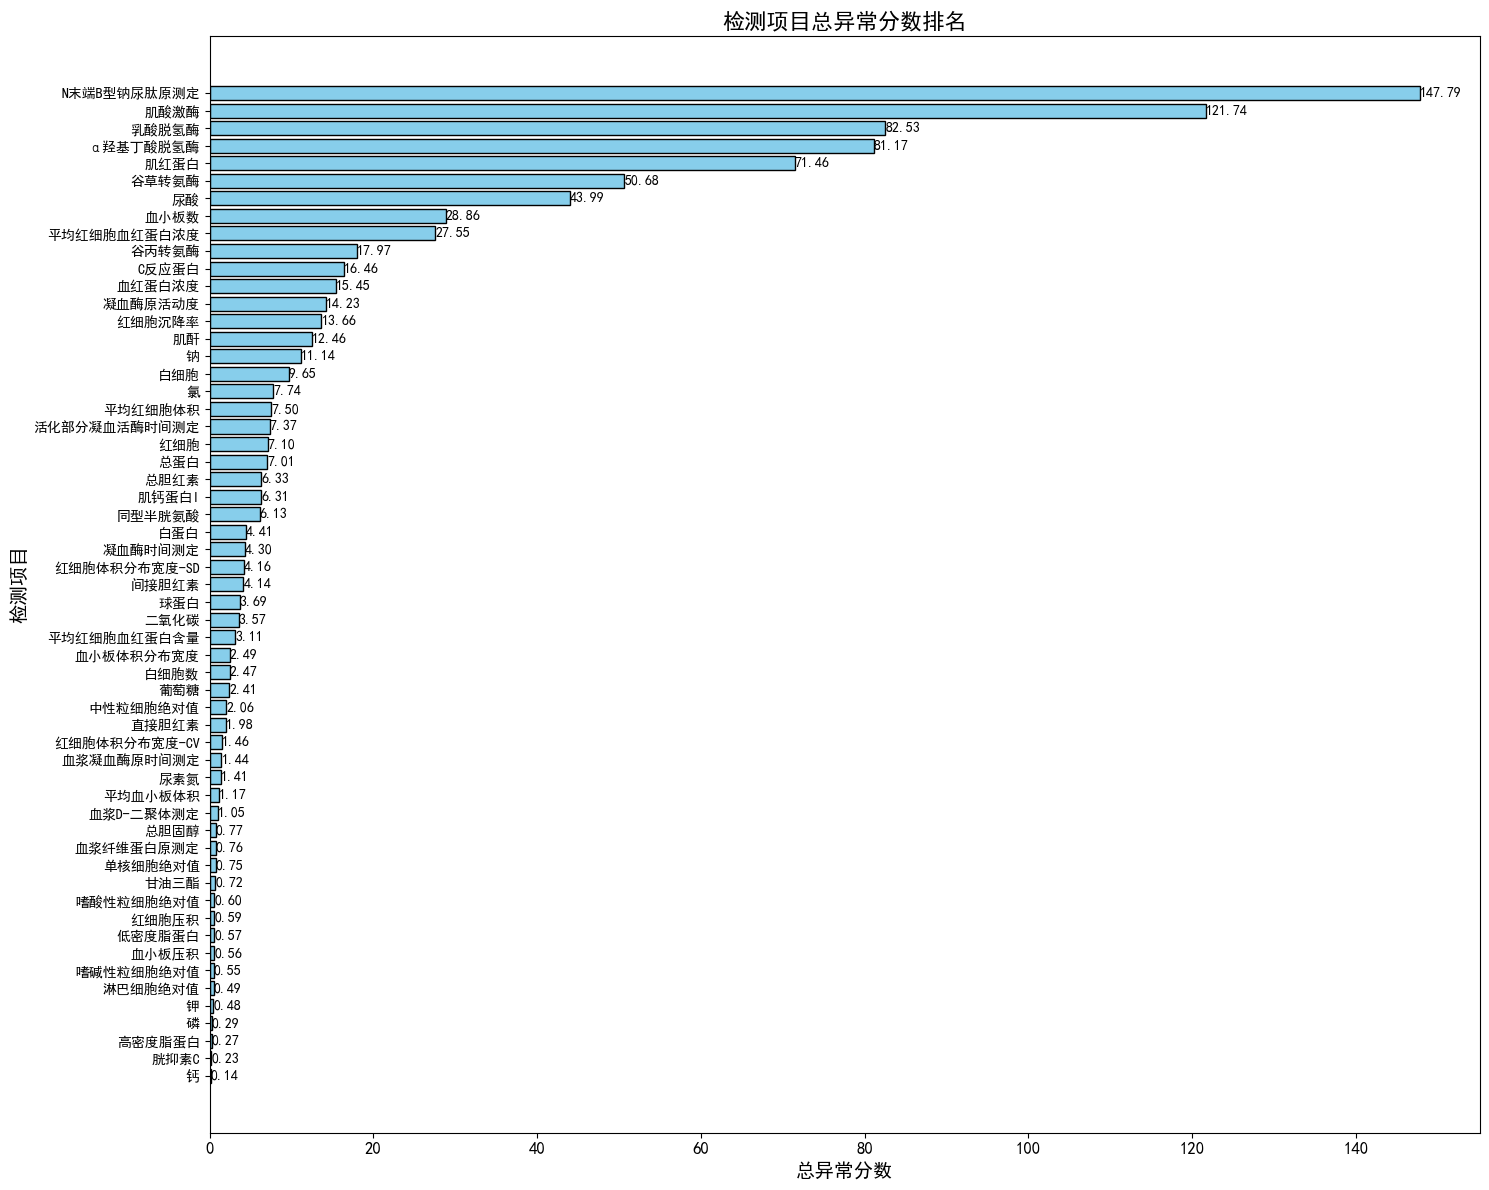

检测项目异常分数排名柱状图已保存到: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\project_anomaly_scores_barplot_adjusted.png


<Figure size 640x480 with 0 Axes>

In [10]:
# ==========================
# 统计每个检测项目的总异常分数
# ==========================

# 按检测项目汇总异常分数
project_anomaly_scores = features_df.groupby('检测项目')['anomaly_score_normalized'].sum().reset_index()

# 对总异常分数进行降序排序
project_anomaly_scores = project_anomaly_scores.sort_values(by='anomaly_score_normalized', ascending=False)

# 重置索引
project_anomaly_scores.reset_index(drop=True, inplace=True)

print("\n检测项目总异常分数排名：")
print(project_anomaly_scores)

# ==========================
# 绘制柱状图（调整宽度）
# ==========================

# 设置图形大小（调整宽度）
plt.figure(figsize=(15, 12))  # 增加宽度

# 绘制柱状图
plt.barh(
    project_anomaly_scores['检测项目'],
    project_anomaly_scores['anomaly_score_normalized'],
    color='skyblue',
    edgecolor='black'
)

# 添加标题和轴标签
plt.title('检测项目总异常分数排名', fontsize=16)
plt.xlabel('总异常分数', fontsize=14)
plt.ylabel('检测项目', fontsize=14)

# 调整刻度字体
plt.xticks(fontsize=12)
plt.yticks(fontsize=10)  # 调整纵轴字体大小，使得更紧凑

# 倒序显示（因为水平柱状图默认是从下往上）
plt.gca().invert_yaxis()

# 添加每个柱子的具体数值
for index, value in enumerate(project_anomaly_scores['anomaly_score_normalized']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

# 显示图形
plt.tight_layout()
plt.show()

# ==========================
# 保存柱状图
# ==========================

# 定义保存路径
barplot_save_path = os.path.join(save_dir, 'project_anomaly_scores_barplot_adjusted.png')

# 保存为高分辨率PNG文件
plt.savefig(barplot_save_path, dpi=300)
print(f"检测项目异常分数排名柱状图已保存到: {barplot_save_path}")


Data Overview:
         Date  PatientID  Gender  Age     CRP  NT_proBNP  Alpha_HBDH  \
0  2021-10-11          1       1   64    2.04      607.5       676.0   
1  2021-10-12          1       1   64    4.40     2475.2       926.0   
2  2021-10-13          1       1   64   11.50     2855.7       596.0   
3  2021-11-24          3       1   47   47.30     2883.8      2042.0   
4  2021-11-26          3       1   47  121.20     3600.0      1060.0   

   NeutrophilCount      LDH   CO2  ...  Triglyceride  Leukocyte  Albumin  \
0             7.71   686.85  28.8  ...          1.53        3.7     41.9   
1             6.47   904.60  23.7  ...          2.61        5.0     40.6   
2             7.49   604.00  22.1  ...          1.58       71.7     39.4   
3            21.33  1545.50  22.2  ...          0.52        3.8     39.8   
4            14.15  1177.60  26.0  ...          1.58        2.2     32.1   

   DirectBilirubin  ESR   ALT  IndirectBilirubin   HDL  Homocysteine  \
0              4.8   11

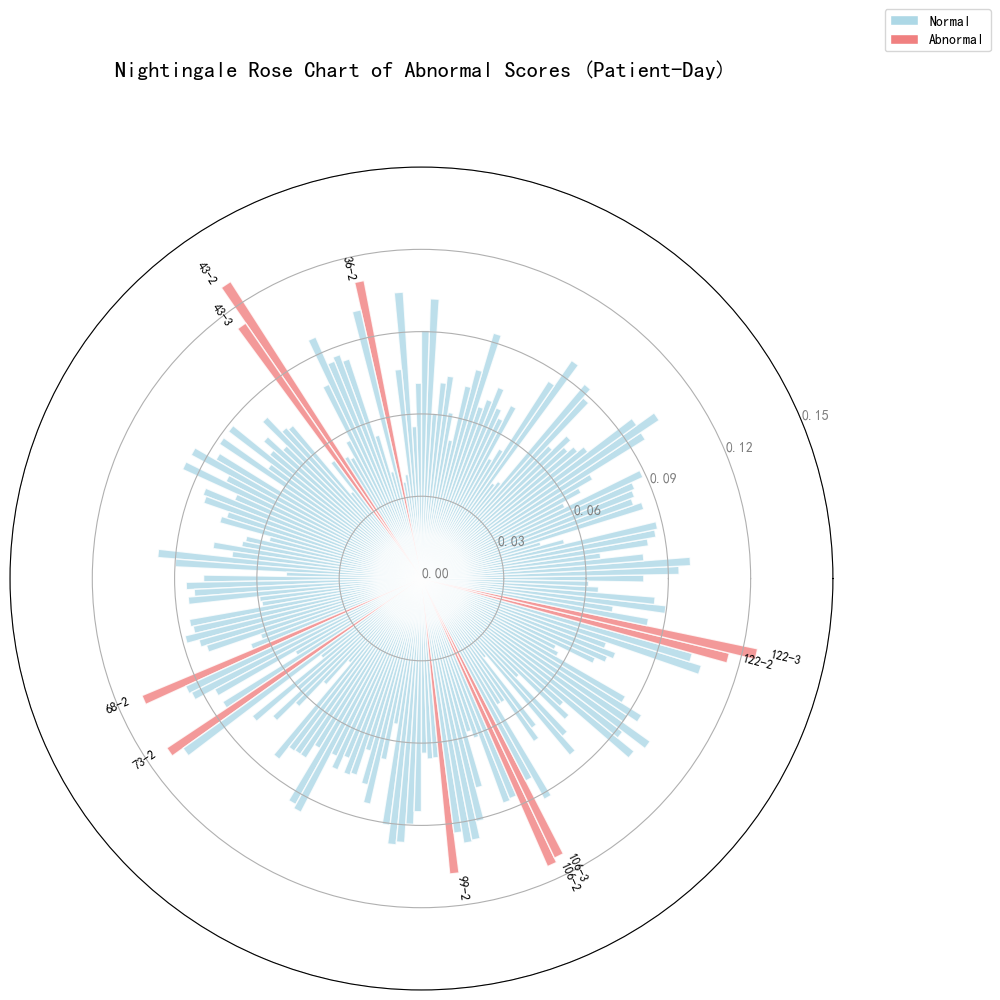

Nightingale Rose Chart saved to: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\nightingale_rose_plot_with_custom_colors.png

Total Anomaly Scores Ranking by Test Items:
               TestItem  anomaly_score_normalized
0             NT_proBNP                147.790837
1                    CK                121.739448
2                   LDH                 82.532266
3            Alpha_HBDH                 81.173245
4             Myoglobin                 71.457704
5                   AST                 50.679540
6              UricAcid                 43.991587
7         PlateletCount                 28.856466
8                  MCHC                 27.551997
9                   ALT                 17.966059
10                  CRP                 16.459675
11           Hemoglobin                 15.448676
12  ProthrombinActivity                 14.232861
13                  ESR                 13.662098
14           Creatinine                 12.463619
15               Sodium                 11

<Figure size 640x480 with 0 Axes>

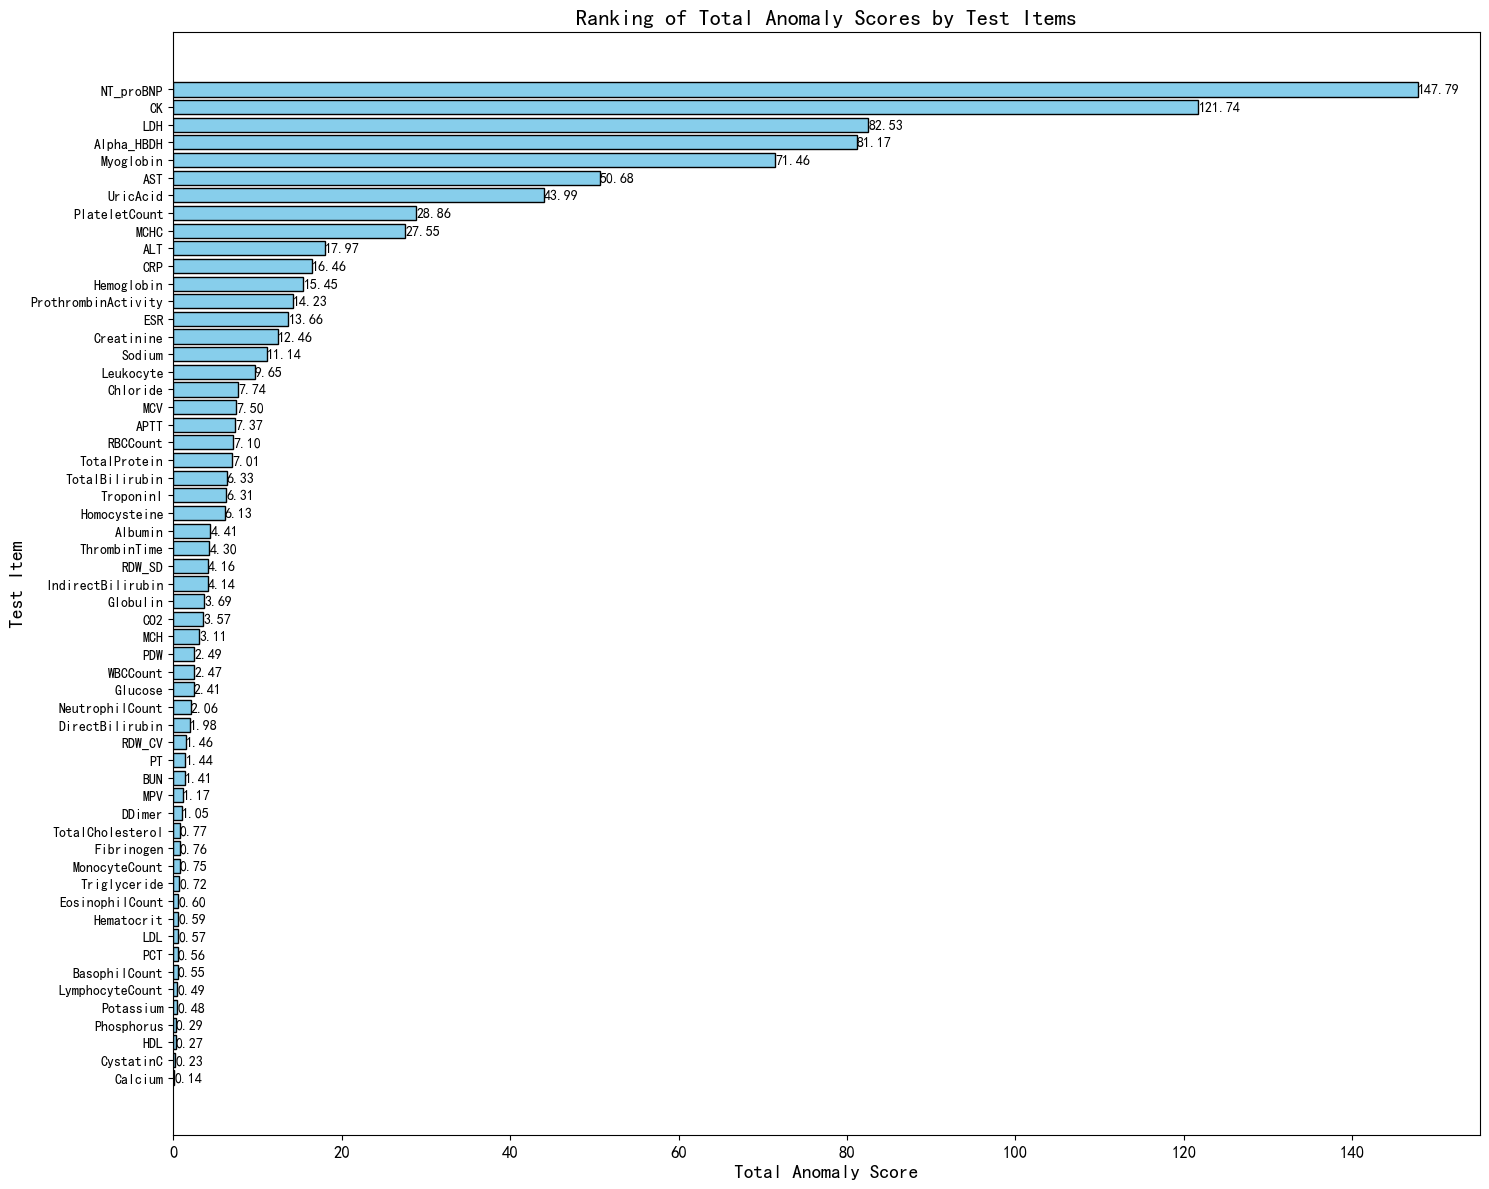

Barplot of Test Items' Anomaly Scores saved to: D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\project_anomaly_scores_barplot_adjusted.png


<Figure size 640x480 with 0 Axes>

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# 如果不需要中文显示，可以注释掉这两行
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ====================================
# 1. Define a dictionary for renaming
# ====================================

# 请根据实际需求，对所有中文列名进行翻译（这里只是示例，未必涵盖所有 62 列）
rename_dict = {
    '日期': 'Date',
    '唯一编号': 'PatientID',
    '性别': 'Gender',
    '年龄': 'Age',
    'C反应蛋白': 'CRP',
    'N末端B型钠尿肽原测定': 'NT_proBNP',
    'α羟基丁酸脱氢酶': 'Alpha_HBDH',
    '中性粒细胞绝对值': 'NeutrophilCount',
    '乳酸脱氢酶': 'LDH',
    '二氧化碳': 'CO2',
    '甘油三酯': 'Triglyceride',
    '白细胞': 'Leukocyte',
    '白蛋白': 'Albumin',
    '直接胆红素': 'DirectBilirubin',
    '红细胞沉降率': 'ESR',
    '谷丙转氨酶': 'ALT',
    '间接胆红素': 'IndirectBilirubin',
    '高密度脂蛋白': 'HDL',
    '同型半胱氨酸': 'Homocysteine',
    '住院日序号': 'HospitalDay',
    '谷草转氨酶': 'AST',
    '钙': 'Calcium',
    '钠': 'Sodium',
    '钾': 'Potassium',
    '低密度脂蛋白': 'LDL',
    '总胆固醇': 'TotalCholesterol',
    '总胆红素': 'TotalBilirubin',
    '总蛋白': 'TotalProtein',
    '球蛋白': 'Globulin',
    '白细胞数': 'WBCCount',
    '尿素氮': 'BUN',
    '尿酸': 'UricAcid',
    '平均红细胞体积': 'MCV',
    '平均红细胞血红蛋白含量': 'MCH',
    '平均红细胞血红蛋白浓度': 'MCHC',
    '平均血小板体积': 'MPV',
    '淋巴细胞绝对值': 'LymphocyteCount',
    '红细胞': 'RBCCount',
    '红细胞体积分布宽度-CV': 'RDW_CV',
    '红细胞体积分布宽度-SD': 'RDW_SD',
    '红细胞压积': 'Hematocrit',
    '肌红蛋白': 'Myoglobin',
    '肌酐': 'Creatinine',
    '肌酸激酶': 'CK',
    '肌钙蛋白I': 'TroponinI',
    '胱抑素C': 'CystatinC',
    '葡萄糖': 'Glucose',
    '血小板体积分布宽度': 'PDW',
    '血小板压积': 'PCT',
    '血小板数': 'PlateletCount',
    '血浆D-二聚体测定': 'DDimer',
    '血浆凝血酶原时间测定': 'PT',
    '血浆纤维蛋白原测定': 'Fibrinogen',
    '血红蛋白浓度': 'Hemoglobin',
    '凝血酶原活动度': 'ProthrombinActivity',
    '凝血酶时间测定': 'ThrombinTime',
    '单核细胞绝对值': 'MonocyteCount',
    '嗜碱性粒细胞绝对值': 'BasophilCount',
    '嗜酸性粒细胞绝对值': 'EosinophilCount',
    '活化部分凝血活酶时间测定': 'APTT',
    '磷': 'Phosphorus',
    '氯': 'Chloride',
    # 如果还有未列出的中文列名，请继续添加到此处
    # ...
}

# ==========================
# 2. Load and preprocess data
# ==========================

data_path = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总\data_GAN.csv'
data = pd.read_csv(data_path)

# 先行重命名列名（数据集中的中文→英文）
data.rename(columns=rename_dict, inplace=True)

print("Data Overview:")
print(data.head())
print("\nData Description:")
print(data.describe())
print("\nData Types:")
print(data.dtypes)

# 排除非特征列（示例中，PatientID, Date, HospitalDay, Gender, Age等不是特征）
exclude_cols = ['PatientID', 'Date', 'HospitalDay', 'Gender', 'Age']
feature_cols = [col for col in data.columns if col not in exclude_cols]

# 确保特征列为数值型，并处理缺失值（填充为均值）
data[feature_cols] = data[feature_cols].apply(pd.to_numeric, errors='coerce')
data[feature_cols] = data[feature_cols].fillna(data[feature_cols].mean())

print("\nMissing Values:")
print(data[feature_cols].isnull().sum())

# 按照 PatientID 和 HospitalDay 排序
data = data.sort_values(by=['PatientID', 'HospitalDay']).reset_index(drop=True)

# ==========================
# 3. Build sliding window features
# ==========================

window_size = 2
window_features = []

unique_ids = data['PatientID'].unique()

for uid in unique_ids:
    patient_data = data[data['PatientID'] == uid].sort_values('HospitalDay').reset_index(drop=True)
    num_days = patient_data.shape[0]

    for project in feature_cols:
        project_values = patient_data[project].values

        # Sliding window
        for i in range(num_days - window_size + 1):
            window = project_values[i:i + window_size]
            day1, day2 = window

            change = day2 - day1
            mean_val = np.mean(window)
            var_val = np.var(window)

            hospital_day = patient_data.loc[i + window_size - 1, 'HospitalDay']

            window_features.append({
                'PatientID': uid,
                'HospitalDay': hospital_day,
                'TestItem': project,
                'change': change,
                'mean_val': mean_val,
                'var_val': var_val
            })

features_df = pd.DataFrame(window_features)
print("\nSliding Window Feature Overview:")
print(features_df.head())
print("\nSliding Window Feature Description:")
print(features_df.describe())

# ==========================
# 4. Feature scaling
# ==========================

feature_columns = ['change', 'mean_val', 'var_val']
X = features_df[feature_columns].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ==========================
# 5. Train IsolationForest and compute anomaly scores
# ==========================

iso_model = IsolationForest(n_estimators=100, contamination='auto', random_state=123)
iso_model.fit(X_scaled)

anomaly_scores = -iso_model.decision_function(X_scaled)
features_df['anomaly_score'] = anomaly_scores

# ==========================
# 6. Normalize anomaly scores
# ==========================

scaler_score = MinMaxScaler()
features_df['anomaly_score_normalized'] = scaler_score.fit_transform(features_df[['anomaly_score']])

print("\nOverview of Standardized Anomaly Scores:")
print(features_df[['PatientID', 'HospitalDay', 'TestItem', 'anomaly_score', 'anomaly_score_normalized']].head())

# ==========================
# 7. Aggregate anomaly scores (patient-day level)
# ==========================

patient_day_anomaly = features_df.groupby(['PatientID', 'HospitalDay'])['anomaly_score_normalized'].mean().reset_index()

# ==========================
# 8. Mark abnormal points
# ==========================

threshold = patient_day_anomaly['anomaly_score_normalized'].quantile(0.95)
patient_day_anomaly['anomaly_label'] = patient_day_anomaly['anomaly_score_normalized'].apply(
    lambda x: 'Abnormal' if x > threshold else 'Normal'
)

print(f"\nAnomaly Score Threshold (95th Percentile): {threshold}")
print(f"Number of Abnormal Points: {patient_day_anomaly['anomaly_label'].value_counts().get('Abnormal', 0)}")
print(f"Number of Normal Points: {patient_day_anomaly['anomaly_label'].value_counts().get('Normal', 0)}")

# ==========================
# 9. Select top 5 abnormal patients
# ==========================

top_5_anomalous = patient_day_anomaly.sort_values(by='anomaly_score_normalized', ascending=False).head(5)
print("\nTop 5 Most Abnormal Patients and Hospital Days:")
print(top_5_anomalous)

# ==========================
# 10. Create Nightingale Rose Chart
# ==========================

rose_data = patient_day_anomaly.copy()
rose_data['Patient_Day'] = rose_data['PatientID'].astype(str) + '-' + rose_data['HospitalDay'].astype(str)

rose_data['highlight'] = rose_data.apply(
    lambda row: 'Abnormal' if row['anomaly_label'] == 'Abnormal' else 'Normal',
    axis=1
)

color_mapping = {'Normal': 'lightblue', 'Abnormal': 'lightcoral'}

plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=True)

num_points = len(rose_data)
angles = np.linspace(0, 2 * np.pi, num_points, endpoint=False).tolist()
angles += angles[:1]

scores = rose_data['anomaly_score_normalized'].tolist()
scores += scores[:1]

colors = rose_data['highlight'].map(color_mapping).tolist()
colors += colors[:1]

labels = rose_data['Patient_Day'].tolist()
labels += labels[:1]

bars = ax.bar(angles[:-1], scores[:-1], width=2 * np.pi / num_points,
              color=colors[:-1], edgecolor='white', alpha=0.8)

plt.title('Nightingale Rose Chart of Abnormal Scores (Patient-Day)', fontsize=16, y=1.1)

max_score = 0.15  
step = 0.03  
yticks = np.arange(0, max_score + step, step)
ax.set_yticks(yticks)
ax.set_yticklabels([f"{tick:.2f}" for tick in yticks], fontsize=10, color='gray')
ax.set_xticks([])

legend_elements = [
    Patch(facecolor='lightblue', edgecolor='white', label='Normal'),
    Patch(facecolor='lightcoral', edgecolor='white', label='Abnormal')
]
ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.2, 1.2))

for i, bar in enumerate(bars):
    if rose_data['highlight'].iloc[i] == 'Abnormal':
        angle = angles[i]
        rotation = np.degrees(angle)
        if 90 < rotation < 270:
            alignment = 'right'
            rotation += 180
        else:
            alignment = 'left'
        ax.text(
            angle, bar.get_height() + 0.005,
            labels[i],
            rotation=rotation, ha=alignment, va='center',
            fontsize=9, fontweight='bold', color='black'
        )

plt.tight_layout()
plt.show()

# 定义保存目录
save_dir = r'D:\生化数据遥感法处理\生化数据遥感法处理\心梗数据单项目异常汇总'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

rose_plot_save_path = os.path.join(save_dir, 'nightingale_rose_plot_with_custom_colors.png')
plt.savefig(rose_plot_save_path, dpi=300)
print(f"Nightingale Rose Chart saved to: {rose_plot_save_path}")


# ==========================
# (Additional) Summation of anomaly scores by test item
# ==========================

project_anomaly_scores = features_df.groupby('TestItem')['anomaly_score_normalized'].sum().reset_index()
project_anomaly_scores.sort_values(by='anomaly_score_normalized', ascending=False, inplace=True)
project_anomaly_scores.reset_index(drop=True, inplace=True)

print("\nTotal Anomaly Scores Ranking by Test Items:")
print(project_anomaly_scores)

plt.figure(figsize=(15, 12))
plt.barh(
    project_anomaly_scores['TestItem'],
    project_anomaly_scores['anomaly_score_normalized'],
    color='skyblue',
    edgecolor='black'
)

plt.title('Ranking of Total Anomaly Scores by Test Items', fontsize=16)
plt.xlabel('Total Anomaly Score', fontsize=14)
plt.ylabel('Test Item', fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=10)
plt.gca().invert_yaxis()

for index, value in enumerate(project_anomaly_scores['anomaly_score_normalized']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

barplot_save_path = os.path.join(save_dir, 'project_anomaly_scores_barplot_adjusted.png')
plt.savefig(barplot_save_path, dpi=300)
print(f"Barplot of Test Items' Anomaly Scores saved to: {barplot_save_path}")
